WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 35 finished 
0 35.0 35.0
Episode 21 finished 
1 21.0 35.0
Episode 15 finished 
2 15.0 35.0
Episode 16 finished 
3 16.0 35.0
Episode 19 finished 
4 19.0 35.0
Episode 43 finished 
5 43.0 43.0
Episode 26 finished 
6 26.0 43.0
Episode 15 finished 
7 15.0 43.0
Episode 19 finished 
8 19.0 43.0
Episode 15 finished 
9 15.0 43.0
Episode 50 finished 
10 50.0 50.0
Episode 22 finished 
11 22.0 50.0
Episode 20 finished 
12 20.0 50.0
Episode 26 finished 
13 26.0 50.0
Episode 16 finished 
14 16.0 50.0
Episode 41 finished 
15 41.0 50.0
Episode 51 finished 
16 51.0 51.0
Episode 29 finished 
17 29.0 51.0
Episode 18 finished 
18 18.0 51.0
Episode 19 finished 
19 19.0 51.0
Episode 12 finished 
20 12.0 51.0
Episode 50 finished 
21 50.0 51.0
Episode 17 finished 
22 17.0 51.0
Episode 15 finished 
23 15.0 51.0
Episode 24 finished 
24 24.0 51.0
Episode 18 finished 
25 18.0 51.0
Episode 29 finished 
26 29.

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100000,)

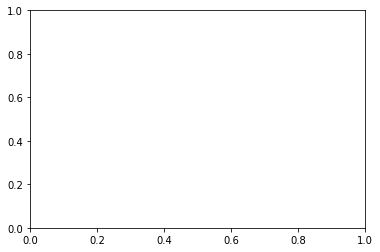

In [9]:
#! /usr/bin/env python
#coding: utf-8

#Library
import numpy as np
import time
import matplotlib.pyplot as plt

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

import gym
from gym import wrappers

np.random.seed(seed=7)
STATE_NUM = 4
#DQN内部のNN
class Q(chainer.Chain):
    def __init__(self,state_num=STATE_NUM):
        super(Q,self).__init__(
        l1=L.Linear(state_num, 16), #入力はstate number
        l2=L.Linear(16,32),
        l3=L.Linear(32,64),
        l4=L.Linear(64,256),
        l5=L.Linear(256,2), #出力はQvalue(2つ)
        )
        
    def __call__(self,x,t):
        loss = F.mean_squared_error(self.predict(x),t)
        return loss
    
    def predict(self, x):
        h1 = F.leaky_relu(self.l1(x))
        h2 = F.leaky_relu(self.l2(h1))
        h3 = F.leaky_relu(self.l3(h2))
        h4 = F.leaky_relu(self.l4(h3))
        y = F.leaky_relu(self.l5(h4))
        return y
    
class DQNAgent():
    """
    DQNアルゴリズムに従って動作させる"""
    def __init__(self, epsilon=0.99):
        self.model = Q()
        self.optimizer = optimizers.Adam() #Adamで最適化
        self.optimizer.setup(self.model)
        self.epsilon = epsilon #e-greed法
        self.actions = [0,1] #行動の選択肢(当然2つ)
        self.experienceMemory = [] #経験メモリ
        self.memSize = 300*100 #経験もめりのサイズ。サンプリング×エピソード
        self.experienceMemory_Local = [] #エピソードローカル用の経験メモリ
        self.memIdx = 0 #メモリのインデックス
        self.batch_size = 32 #学習用バッチサイズ
        self.gamma = 0.95 #割引(もうちょい大きくてもよい？？？)
        self.loss = 0
        self.total_reward_award = np.ones(100)*(-1000) #100エピソード
        
    def get_action_value(self, state):
        #行動価値関数
        x = Variable(np.hstack([state]).astype(np.float32).reshape((1,-1)))
        return self.model.predict(x).data[0]
    
    def get_greedy_action(self, state):
        action_index = np.argmax(self.get_action_value(state))
        return self.actions[action_index]
    
    def reduce_epsilon(self):
        self.epsilon -= -1.0/100000
        
    def get_epsilon(self):
        return aelf.epsilon
    
    def get_action(self,state):
        """
        Actionを返す。e-greedy法を用いる"""
        action = 0
        if np.random.random()<self.epsilon:
            #random
            action = np.random.choice(self.actions)
        else:
            #greedy
            action = self.get_greedy_action(state)
        return action
    
    def experience_local(self, old_state, action, reward, new_state):
        #localな記憶
        self.experienceMemory_Local.append(np.hstack([old_state,action,reward,new_state]))
        
    def experience_global(self, total_reward):
        #globalな記憶
        #総報酬が大きいものを取り込む
        if np.min(self.total_reward_award) < total_reward:
            i = np.argmin(self.total_reward_award)
            self.total_reward_award[i] = total_reward
            
            for x in self.experienceMemory_Local:
                self.experience(x)
                
        if np.random.random() < 0.01:
            #普通の経験
            for x in self.experienceMemory_Local:
                self.experience(x)
        
        self.experienceMemory_Local = []#初期化
        
    def experience(self,x):
        if len(self.experienceMemory) > self.memSize:
            self.experienceMemory[int(self.memIdx % self.memSize)] = x #posにおけるsizeの剰余
            self.memIdx += 1
        else:
            self.experienceMemory.append(x)
    
    def update_model(self, old_state, sction, reward, new_state):
        if len(self.experienceMemory) < self.batch_size:
            return
        
        memsize = len(self.experienceMemory)
        batch_index = list(np.random.randint(0,memsize,self.batch_size))
        batch = np.array([self.experienceMemory[i] for i in batch_index])
        x = Variable(batch[:,0:STATE_NUM].reshape((self.batch_size,-1)).astype(np.float32))
        targets = self.model.predict(x).data.copy()
        
        for i in range(self.batch_size):
            #[state, action, reward, state_new]
            a = batch[i,STATE_NUM]
            r = batch[i,STATE_NUM+1]
            ai = int((a+1)/2) #
            new_state = batch[i, (STATE_NUM+2):(STATE_NUM*2+2)]
            targets[i,ai] = (r+self.gamma*np.max(self.get_action_value(new_state)))
        t = Variable(np.array(targets).reshape((self.batch_size,-1)).astype(np.float32))
        
        #ネットの更新
        self.model.zerograds()
        loss = self.model(x,t)
        self.loss = loss.data
        loss.backward()
        self.optimizer.update()
        

class PendulumEnvrionment():
    """振り子"""
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        
    def reset(self):
        self.env.reset()
    
    def render(self):
        self.env.render()
        
    def step(self,action):
        return self.env.step(action)
    
    def monitor_close(self):
        self.env.monitor.close()
        
class Simulator():
    #シミュレーター部分
    '''
    Arg : 
    environment 環境,env使えばよい
    agent エージェント、どういう行動理念を持っているか
    '''
    def __init__(self, environment, agent):
        self.agent = agent
        self.env = environment
        
        self.num_state = STATE_NUM
        self.reset_state()
        self.learning_rate = 1.0
        self.highscore = 0
        self.log = []
        
    def reset_state(self):
        self.state = np.zeros(self.num_state)
        
    def push_state(self,state):
        self.state[1:self.num_state] = self.state[0:self.num_state-1]
        self.state[0] = state
        
    def run(self):
        self.env.reset()
        self.reset_state()
        total_reward = 0
        
        for i in range(100):
            #現在のstateを保存
            old_state = self.state.copy()
            #現在をrender
            #self.env.render()
            #agentの行動を決定
            action = self.agent.get_action(old_state)
            
            #環境に行動を入力
            observation, reward, done, info = self.env.step(action)
            total_reward += reward
            
            #結果からstate更新
            state = observation[2]
            self.push_state(state)
            new_state = self.state.copy()
            
            #localなメモリに記憶する
            self.agent.experience_local(old_state, action, reward, new_state)
            
            if done:
                print('Episode {} finished '.format(i+1))
                break
        
        #local→globalに移す
        self.agent.experience_global(total_reward)
        
        self.agent.update_model(old_state, action, reward, new_state)
        self.agent.reduce_epsilon()
        
        return total_reward
    
if __name__ == '__main__':
    start = time.time()
    agent = DQNAgent()
    env = PendulumEnvrionment()
    sim = Simulator(env,agent)
    log = []
    best_reward = 0
    for i in range(100000):
        total_reward = sim.run()
        log.append(total_reward)
        if best_reward < total_reward:
            best_reward = total_reward   
        print(str(i) + ' '+ str(total_reward)+ ' '+ str(best_reward))
        env.reset()
        if best_reward > 195:#テキトー
            break
    simu_time = time.time()-start
    print('calc time is: ' + str(simu_time))

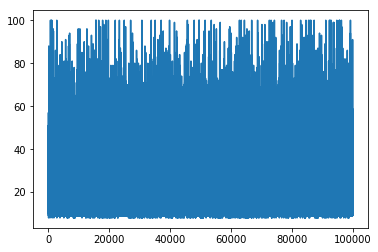

In [10]:
plt.plot(range(100000),log)
plt.show()